In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
import random
import torch.nn.functional as F
from torchmetrics.functional.image.ssim import (
    structural_similarity_index_measure,
)
from torchmetrics.functional.image.psnr import peak_signal_noise_ratio

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)

In [3]:
def resize_encoder(sample):
    sample = sample.unsqueeze(0)
    sample = F.interpolate(
        sample, size=(144, 72), mode="bicubic", align_corners=False
    )
    return sample.squeeze(0)


def random_mask(sample, mask_prob_low=0.7, mask_prob_high=0.7):
    if mask_prob_low == mask_prob_high:
        mask_prob = mask_prob_low
    else:
        mask_prob = random.uniform(mask_prob_low, mask_prob_high)
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image


class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob_low=0.7, mask_prob_high=0.7):
        self.data = data
        self.mask_prob_low = mask_prob_low
        self.mask_prob_high = mask_prob_high

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        X = self.data[idx]
        X_enc = resize_encoder(X)
        X_masked = random_mask(
            X_enc,
            mask_prob_low=self.mask_prob_low,
            mask_prob_high=self.mask_prob_high,
        )
        return X, X_masked, X_enc

In [4]:
latent_model = torch.load(
    "conditional_latent_model.pth", weights_only=False, map_location=DEVICE
)
model = torch.load(
    "simclr_decoder_freeze.pth", weights_only=False, map_location=DEVICE
)
latent_model.eval()
model.eval()

encoder_model = model.model
decoder_model = model.decoder

data = torch.load("/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt")
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
data = data[n_train + n_valid :]


BATCH_SIZE = 16
NUM_TIMES_TO_SAMPLE = 10
n_samples = data.shape[0]

n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)

train_data = data[:n_train]
valid_data = data[n_train : n_train + n_valid]
test_data = data[n_train + n_valid :]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std

In [5]:
test_dataset = WeatherBenchDataset(
    data=test_data, mask_prob_low=0.7, mask_prob_high=0.7
)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Encode the data

encoded_data = []
with torch.no_grad():
    for data in testloader:
        x_f_batch = data[2].to(DEVICE)
        x_mask = data[1].to(DEVICE)
        x_mask_enc = encoder_model.encode(x_mask)
        encoded_data.append(x_mask_enc)

encoded_data = torch.cat(encoded_data, dim=0)

In [7]:
# Generate some samples
# Random Batch of conditions
batch = random.choice(list(testloader))
condition = batch[1].to(DEVICE)
condition = encoder_model.encode(condition)
trajectory = latent_model.sample_and_log(condition.shape[0], 1000, condition)
trajectory = trajectory[:, 0, :]
print(trajectory.shape)

torch.Size([1001, 1000])


In [8]:
trajectory_np = trajectory.cpu().numpy()

In [9]:
pca = PCA(n_components=2)
proj = pca.fit_transform(trajectory_np)
df = pd.DataFrame({"x": proj[:, 0], "y": proj[:, 1], "timestep": np.arange(len(proj))})

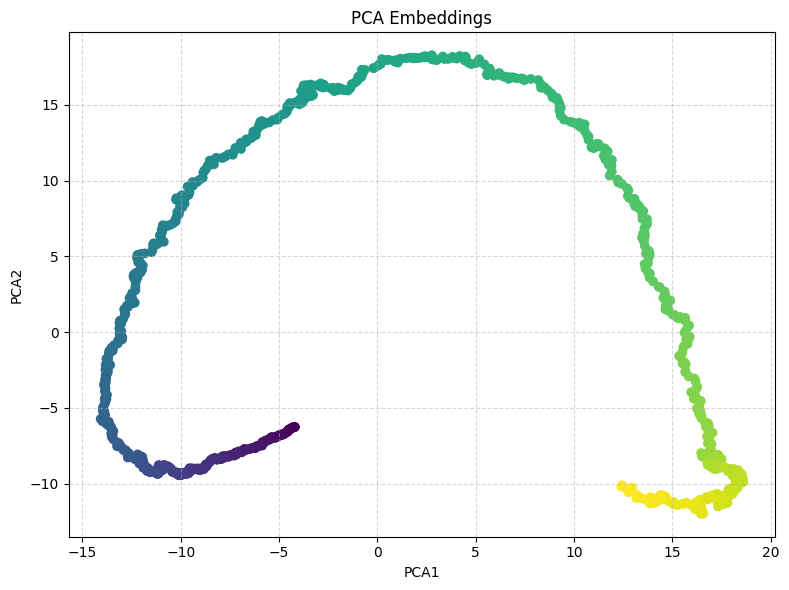

In [10]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["x"],
    df["y"],
    c=df["timestep"],
    cmap="viridis"
)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA Embeddings")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [11]:
traj_tensor = torch.from_numpy(trajectory_np)
norm_traj = torch.nn.functional.normalize(traj_tensor, p=2, dim=1)


norm_trajectory_np = norm_traj.numpy()
cycle_dists = [
    np.linalg.norm(
        norm_trajectory_np[i + 1]
        - 2 * norm_trajectory_np[i]
        + norm_trajectory_np[i - 1]
    )
    ** 2
    for i in range(1, len(norm_trajectory_np) - 1)
]
print("Mean Cycle Distances:", np.mean(cycle_dists))
print(f"Variance of Cycle Distances: {np.var(cycle_dists):.4f}")
print(f"Coefficient of Variation of Cycle Distances: {np.std(cycle_dists)/np.mean(cycle_dists):.4f}")
cycle_dists = np.array(cycle_dists)
rms_d = np.sqrt(np.mean(cycle_dists**2))
print(f"RMS: {rms_d:.4f}")

Mean Cycle Distances: 0.025388192
Variance of Cycle Distances: 0.0001
Coefficient of Variation of Cycle Distances: 0.4606
RMS: 0.0280


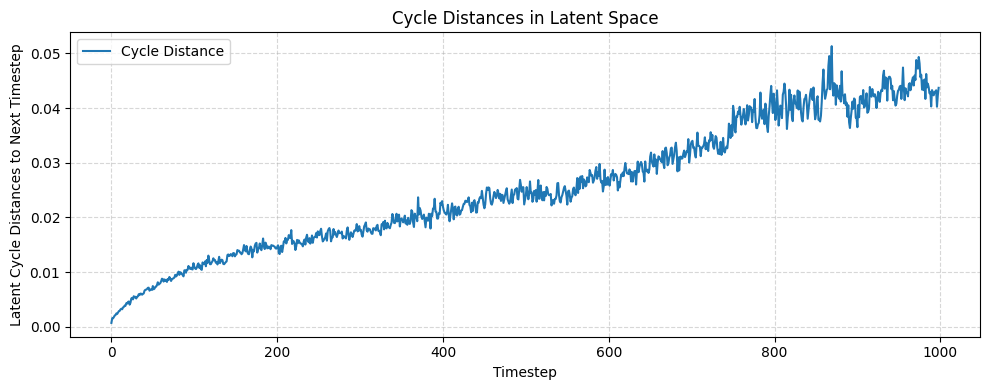

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(cycle_dists, label="Cycle Distance")
plt.xlabel("Timestep")
plt.ylabel("Latent Cycle Distances to Next Timestep")
plt.title("Cycle Distances in Latent Space")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
step_dists = [
    np.linalg.norm(norm_trajectory_np[i + 1] - norm_trajectory_np[i])
    ** 2
    for i in range(len(norm_trajectory_np) - 1)
]
print(f"Mean of Step Distances: {np.mean(step_dists):.4f}")
print(f"Variance of Step Distances: {np.var(step_dists):.4f}")
print(f"Coefficient of Variation of Step Distances: {np.std(step_dists)/np.mean(step_dists):.4f}")
step_dists = np.array(step_dists)
rms_d = np.sqrt(np.mean(step_dists**2))
print(f"RMS step‐length: {rms_d:.4f}")

Mean of Step Distances: 0.0126
Variance of Step Distances: 0.0000
Coefficient of Variation of Step Distances: 0.4598
RMS step‐length: 0.0139


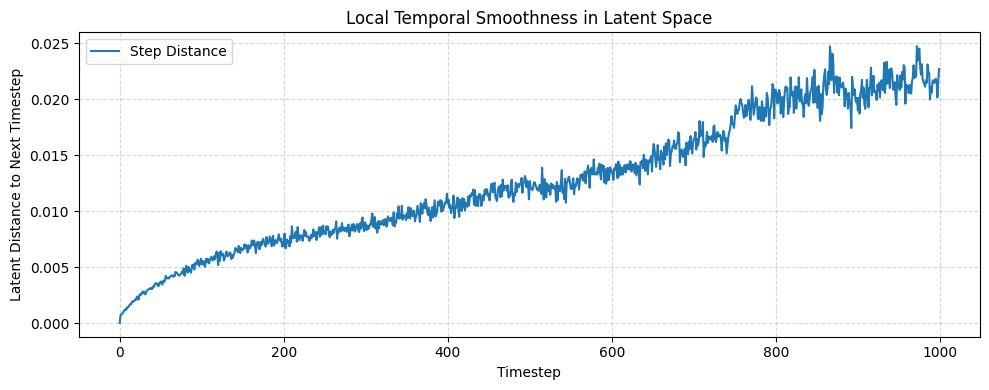

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(step_dists, label="Step Distance")
plt.xlabel("Timestep")
plt.ylabel("Latent Distance to Next Timestep")
plt.title("Local Temporal Smoothness in Latent Space")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
jerk_values = []
# We can only compute this up to the T-3 timestep
for t in range(len(norm_trajectory_np) - 3):
    # The formula is z(t+3) - 3z(t+2) + 3z(t+1) - z(t)
    z_t = norm_trajectory_np[t]
    z_t1 = norm_trajectory_np[t+1]
    z_t2 = norm_trajectory_np[t+2]
    z_t3 = norm_trajectory_np[t+3]
    
    third_difference = z_t3 - 3 * z_t2 + 3 * z_t1 - z_t
    
    # Calculate the squared L2 norm
    jerk_sq_norm = np.sum(third_difference**2)
    jerk_values.append(jerk_sq_norm)
    
jerk = np.array(jerk_values)



In [16]:
print(f"Mean jerk: {jerk.mean()}")
print(f"Variance of jerk: {jerk.var()}")
print(f"Coefficient of Variation of jerk: {jerk.std()/jerk.mean():.4f}")
rms_d = np.sqrt((jerk**2).mean())
print(f"RMS: {rms_d:.4f}")

Mean jerk: 0.07618916779756546
Variance of jerk: 0.0012304952833801508
Coefficient of Variation of jerk: 0.4604
RMS: 0.0839


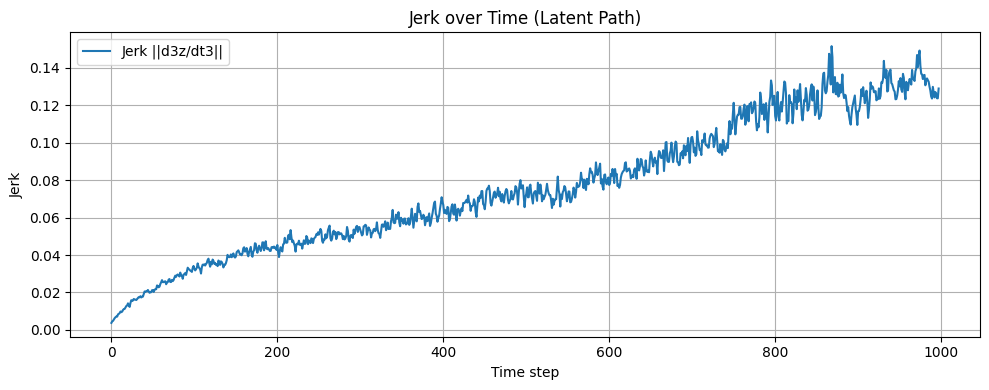

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(jerk, label="Jerk ||d3z/dt3||")
plt.xlabel("Time step")
plt.ylabel("Jerk")
plt.title("Jerk over Time (Latent Path)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()